<a href="https://colab.research.google.com/github/strz/ITWILL_Citrus-Tea/blob/master/VGG_optimizer%3DSGD(lr%3D0_01%2C_nesterov%3DTrue).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

은지의 VGG 코드
practice10
- pre_trained vgg16에 dropout층 추가
- 클래스당 5,000장씩 (64,64)

In [15]:
# Tensorflow 사용버전 설정
%tensorflow_version 2.x

# Tensorflow 버전과 GPU 사용 여부 확인
import tensorflow as tf

print(tf.__version__)
print(tf.test.gpu_device_name()) 

TensorFlow is already loaded. Please restart the runtime to change versions.
2.1.0
/device:GPU:0


In [16]:
# 구글 드라이브 마운트
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
import os
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.utils import plot_model
from tensorflow.keras.models import load_model
from sklearn.metrics import confusion_matrix, classification_report

In [24]:
# 1. practice7으로 디렉토리 설정
# practice7_dir = './practice7'

# 2. numpy 데이터를 불러와서 shape 확인
X_train, X_test, y_train, y_test = np.load('./drive/My Drive/final_project/practice7_data.npy', allow_pickle=True)
print(f'X_train: {X_train.shape}, y_train: {y_train.shape}')  # X_train: (20802, 64, 64, 3), y_train: (20802, 5)
print(f'X_test: {X_test.shape}, y_train: {y_test.shape}')  # X_test: (5201, 64, 64, 3), y_train: (5201, 5)

# 3. 이미 훈련된 vgg16 모델에 globalaveragepooling2d, dense 연결해서 사용
X_train = X_train.astype(float) / 255
X_test = X_test.astype(float) / 255

X_train: (20802, 64, 64, 3), y_train: (20802, 5)
X_test: (5201, 64, 64, 3), y_train: (5201, 5)


58892288/58889256 [==============================] - 4s 0us/step
Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 64, 64, 3)]       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 64, 64, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 64, 64, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 32, 32, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 32, 32, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 32, 32, 128)       147584    
______________________________________________________________

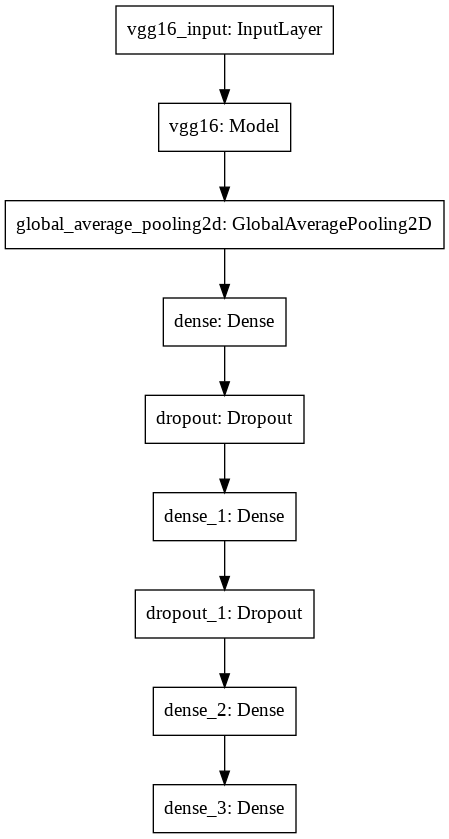

In [25]:
pre_trained_vgg = VGG16(weights='imagenet', include_top=False, input_shape=X_train.shape[1:])
# include_top: 네트워크의 최상단에 3개의 완전 연결 레이어를 넣을지 여부
# input_shape: include_top이 False일 경우만 특정. 그렇지 않다면 인풋의 형태가 (224, 224, 3)이어야 함.
pre_trained_vgg.trainable = False # 이미지넷으로 학습된 값들을 그대로 사용할 것이기 때문에
pre_trained_vgg.summary()

additional_model = Sequential()
additional_model.add(pre_trained_vgg)
additional_model.add(GlobalAveragePooling2D()) # pre_trained_vgg의 디폴트된 input_shape과 다른 형태를 넣었기 때문에 Flatten()대신 Global AveragePooling2D() 이용. 이 부분은 더 공부 필요
additional_model.add(Dense(4096, activation='relu'))
additional_model.add(Dropout(0.5))
additional_model.add(Dense(4096, activation='relu'))
additional_model.add(Dropout(0.5))
additional_model.add(Dense(1000, activation='relu'))
additional_model.add(Dense(5, activation='softmax'))
additional_model.summary()
plot_model(additional_model, to_file='practice10.png')

In [28]:
# 컴파일
additional_model.compile(loss='categorical_crossentropy', optimizer=SGD(lr=0.01, nesterov=True), metrics=['accuracy']) # 'sgd'

model_dir = "./drive/My Drive/final_project/"
model_path = model_dir + 'practice10.model'
checkpoint = ModelCheckpoint(filepath=model_path, monitor='val_loss', verbose=1, save_best_only=True)
early_stop = EarlyStopping(monitor='val_loss', patience=10)

# 신경망 VGG 모델 훈련
history = additional_model.fit(X_train, y_train, batch_size=200, epochs=100, callbacks=[checkpoint, early_stop],
                               validation_split=0.2)
# Train on 16641 samples, validate on 4161 samples

Train on 16641 samples, validate on 4161 samples
Epoch 1/100
16600/16641 [============================>.] - ETA: 0s - loss: 1.5587 - accuracy: 0.2935
Epoch 00001: val_loss improved from inf to 1.45508, saving model to ./drive/My Drive/final_project/practice10.model
Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: ./drive/My Drive/final_project/practice10.model/assets
16641/16641 [==============================] - 16s 976us/sample - loss: 1.5585 - accuracy: 0.2937 - val_loss: 1.4551 - val_accuracy: 0.4302
Epoch 2/100
16600/16641 [============================>.] - ETA: 0s - loss: 1.4240 - accuracy: 0.4167
Epoch 00002: val_loss improved from 1.45508 to 1.29306, saving model to ./drive/My Drive/final_project/practice10.model
INFO:tensorflow:Assets written to: ./drive/My Drive/final_project/practice10.model/assets
16641/16641 [==============================] - 8s 503us/sample - loss: 1.4239 - accuracy: 0.4166 - val_loss: 1.2

5201/5201 [==============================] - 2s 446us/sample - loss: 0.6434 - accuracy: 0.7520
Test loss: 0.6434057338538938, accuracy: 0.7519707679748535


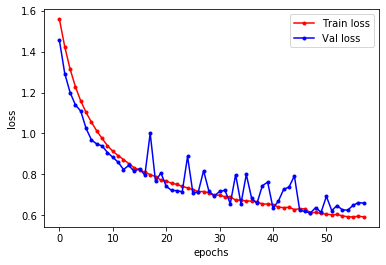

In [29]:
# test 데이터의 loss, accuracy
eval = additional_model.evaluate(X_test, y_test)
print(f'Test loss: {eval[0]}, accuracy: {eval[1]}')
# Test loss: 0.34357965903611304, accuracy: 0.8848298192024231 -> (train 안시킨걸로 돌림)

# Test loss: 0.6434057338538938, accuracy: 0.7519707679748535
#  - loss: 0.5920 - accuracy: 0.7689 - val_loss: 0.6592 - val_accuracy: 0.7493

# train 데이터, validation 데이터의 손실 그래프
train_loss = history.history['loss']
val_loss = history.history['val_loss']
x_len = range(len(train_loss))
plt.plot(x_len, train_loss, marker='.', color='red', label='Train loss')
plt.plot(x_len, val_loss, marker='.', color='blue', label='Val loss')
plt.legend()
plt.xlabel('epochs')
plt.ylabel('loss')
plt.show()

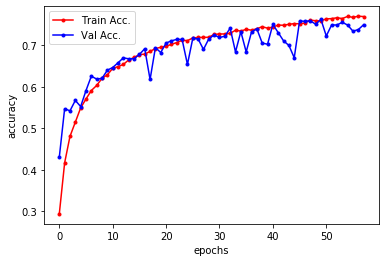

In [30]:
# train 데이터, validation 데이터의 정확도 그래프
train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
plt.plot(x_len, train_acc, marker='.', c='red', label='Train Acc.')
plt.plot(x_len, val_acc, marker='.', c='blue', label='Val Acc.')
plt.legend()
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.show()

In [43]:
# # 4. 만든 모델 불러와서 예측 후 평가
# model = load_model('./drive/My Drive/final_project/practice10.model')

# categories = ["df", "mel", "nv", "tsu", "vl"]  

# predictions = model.predict(X_test)
# y_test = np.argmax(y_test, axis=1)
# y_pred = np.argmax(predictions, axis=1)
# print('* Confusion Matrix')
# print(confusion_matrix(y_test, y_pred))
# print('* Classification Report')
# print(classification_report(y_test, y_pred, target_names=categories)) 

categories = ["df", "mel", "nv", "tsu", "vl"]

# confusion matrix & classification report
print(y_test)

y_true = np.argmax(y_test, axis=1)   # 행 중 가장 큰값의 idx
# (one-hot-encoding 되어있으므로 1로 표시된 값을 행에서 가장 큰값으로 출력하여 array로 만듦)
print(y_true)
y_pred = np.argmax(model.predict(X_test), axis=1)
print(y_pred)

cm = confusion_matrix(y_true, y_pred)
print(cm)
# 세로가 실제클래스, 가로가 예측클래스
## 1 
# [[ 420  334   44   33    1]
#  [   1  860   68    1    0]
#  [   1  312  595    2    3]
#  [   1   20    2 1018    3]
#  [   0   13   18    4  819]]

### 2
# [[412   5  23   3   2]
#  [  4 380  58   9   0]
#  [  1  40 393   4   0]
#  [  0   0   0 536   0]
#  [  0   5   2  26 384]]


report = classification_report(y_true, y_pred, target_names=categories)
print(report)

[0 3 3 ... 1 2 3]


AxisError: ignored